In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from qpipe import *
import numpy as np
from math import sqrt, log, exp


/home/yaniv/anaconda3/envs/qdiff/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/yaniv/anaconda3/envs/qdiff/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [20]:
api = wandb.Api()

# Replace 'my-project' with your project name and 'my-run-name' with your run name
path_M4E3 = "dl-projects/qpipe/m22a82qa"
path_M3E4 = "dl-projects/qpipe/9pcbity4"
path_M2E5 = "dl-projects/qpipe/hiidxu4f"
run = api.run(path_M3E4)


In [21]:
history = run.history()
qnet_Std = history['qnet_Std']
steps = history['_step']
T = len(steps)
y0 = qnet_Std.values[0]
y1 = qnet_Std.values[-1]
ymid = qnet_Std.values[T//2]

print("%.04f, %.04f, %.04f" %   (y0, y1 ,ymid))

0.0088, 0.0704, 0.0117


In [22]:
from utils.evaluate import *
from utils.quantization_interpolation import *

In [23]:
def oneover_quantization_noise(q0, q1, T, qmid):
    x = torch.arange(0, T, dtype=torch.float32)

    ## \frac{1}{T}\sqrt{\left(\frac{y_{0}}{y_{1}}\right)^{2}-1}=b
    
    a = q0
    b = ((q0/q1)**2-1)/(T-1)**2
    y = a / torch.sqrt(b*x**2+1) 
    return y


In [24]:
y_e = exponential_quantization_noise(y0,y1,T)
y_p = polynomial_quantization_noise(y0,y1,T)
y_pp = polynomial_quantization_noise(y0,y1,T, ymid)

y_ee = expexp_quantization_noise(y0 ,y1,T , ymid)

y_1o = oneover_quantization_noise(y0 ,y1,T , ymid)

##power = 1/5

##y_e_power = exponential_quantization_noise(y0**power,y1**power,T)**(1/power)


x = np.arange(T)

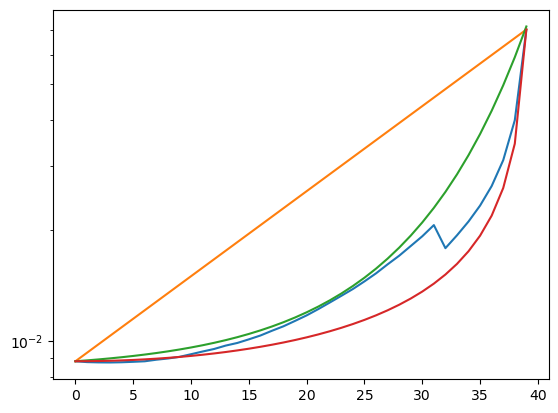

In [25]:
plt.semilogy(steps, qnet_Std)
##plt.semilogy(x,y_ee)
##plt.semilogy(x,y_e)
##plt.semilogy(x,y_ee)
plt.semilogy(x,y_e)
plt.semilogy(x,y_ee)
plt.semilogy(x,y_1o)

##plt.semilogy(x,x)


##plt.semilogy(x,y_e_power)

##plt.semilogy(x,y_e_sqrt)

##plt.plot(x,y_p)



In [48]:
def calculate_gamma(sigma_Q, r):

    term = 1 - sigma_Q**2 * (1 - r**2)
    sqrt_term = torch.sqrt(term)
    
    numerator = sqrt_term + (1 - r) * sigma_Q**2 - 1
    denominator = 1 - sigma_Q**2
    
    result = numerator / denominator
    

    ## nan to 0
    result = torch.nan_to_num(result, nan=0.0)

    return result

In [49]:
from diffusers import DiffusionPipeline

from utils.evaluate import *
from utils.quantization_interpolation import *
from quantized_euler_discrete import QuantizedEulerDiscreteScheduler

fwd_quant= "M2E5"
style="cosh"
n_steps=20
sigma_q= interpolate_quantization_noise(fwd_quant, style, n_steps)

In [50]:

gamma = calculate_gamma(sigma_q, 0.5)

In [51]:
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float32, use_safetensors=True 
)
base.to("cuda");
base.scheduler = QuantizedEulerDiscreteScheduler.from_scheduler(base.scheduler, 
                                                                quantization_noise = sigma_q,
                                                                gamma_threshold = 1,
                                                                quantized_run = True)

base.scheduler.set_timesteps(20)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [52]:
sigmas = base.scheduler.sigmas

r = sigmas[1:]/sigmas[:-1]

In [53]:
gamma = calculate_gamma(sigma_q, r)

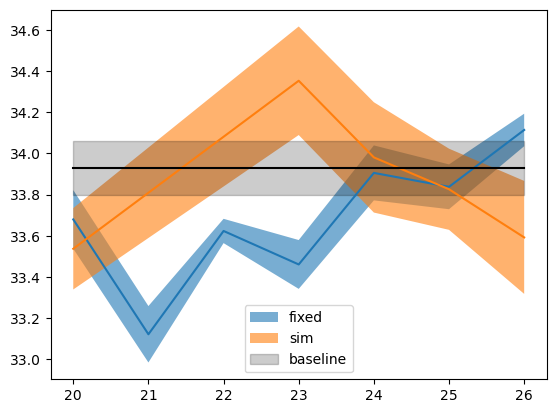

In [3]:
from utils.presentation import *

f1 = lambda x: x.endswith("M2E5_flex_V3")
f2 = lambda x: "V3_adjusted" in x
f3 = lambda x: "V4_adjustedV2" in x and not x.startswith("sim_") and not x.startswith("simm_")
f4 = lambda x: x.startswith("sim_")
f5 = lambda x: x.startswith("simm_")

field = "IS"
field = "clip_score_mean"

##plot_lines(filter = f1, label = "vanilla", field = field)
##plot_lines(filter = f2, label = "old", field = field)

plot_lines(filter = f3, label = "fixed", field = field)
plot_lines(filter = f4, label = "sim", field = field, baseline = True)
##plot_lines(filter = f5, label = "simm", field = field, baseline = True)

plt.legend(loc='lower center')


array([25., 25., 24., 24., 23., 22., 21., 23., 21., 20., 20., 22.])

In [80]:
## get scalar metric:

df = mruns[0].summary['count']
df

{'_wandb': {'runtime': 159}, '_runtime': 160.94166374206543, 'clip_score_mean_std': 0.21135920254391455, 'count': 256, '_step': 0, 'IS_std': 0.00027762502977725454, '_timestamp': 1709584539.7786355, 'clip_score': 33.5972, 'clip_score_mean': 33.59725, 'clip_score_large': 27.0724, 'IS': 1.0139961288303476}

mruns[0]

In [87]:
mruns[0].config['num_inference_steps']

25